# Minimization and Fitting


Beyond linear algebra, [SciPy](https://scipy.github.io/devdocs/index.html) contains modules implementing several key operations usually performed in scientific data analysis and engineering: optimization integration, interpolation, special functions, FFT, signal and image processing, ODE solvers, etc. 

Among the available sub-packages you can find:

- `constants`: physical constants and conversion factors
- `optimize`: optimization algorithms including linear programming (today)
- `interpolate`: interpolation tools (today)
- `stats`: statistical functions (today and in the next lecture)
- `integrate`: numerical integration routines (in the next lecture)
- `fft`: Discrete Fourier Transform algorithms (in the next lecture)
- `fftpack`: Legacy interface for Discrete Fourier Transforms (in the next lecture)
- `linalg`: linear algebra routines (in the next lectures)
- `sparse`: sparse matrices and related algorithms (in the next lectures)
- and many others


We will start focusing on `scipy.optimize`, a module that provides several algorithms for function minimization (scalar or multi-dimensional), curve fitting and root finding.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

##  Roots of functions

There are several root finding algorithms for a generic function $f(x): {\rm I\!R} \to {\rm I\!R}$, e.g. [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) or Brent (a safer version of the secant method, which combines a bracketing strategy with a parabolic approximation)

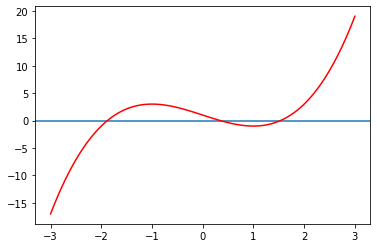

In [2]:
def f(x):
    return x**3 - 3*x + 1

x = np.linspace(-3, 3, 100)
plt.axhline(0)
plt.plot(x, f(x),'r-')

In [3]:
from scipy.optimize import newton
# The Newton method just needs the initial point
x1, x2, x3 = newton(f, -3), newton(f, 0), newton(f, 3)
print(x1, x2, x3)

-1.8793852415718166 0.34729635533385395 1.5320888862379578


In [4]:
%timeit newton(f, 0)

96.9 µs ± 993 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Let's try now the [Brentq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html) module from ScipPy:

In [5]:
from scipy.optimize import brentq
# Specifying the function and the range to look for zeroes is mandatory
x1, x2, x3 = brentq(f, -3, 0), brentq(f, 0, 1), brentq(f, 1,3)
print(x1, x2, x3)

-1.8793852415718166 0.3472963553337031 1.532088886237956


In [6]:
%timeit brentq(f, 0, 1)

2.65 µs ± 2.68 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


As you can verify, two independent methods yield the same result, but the performance can be very different, as every algorithm has its pros and cons.

In case of $f(x): {\rm I\!R}^2 \to {\rm I\!R}$, the `optimize.root` is available, also implementing several methods (MINPACK's hybrid being the default).

When performing complex root finding and minimizations, always **check if the algorithm has converged!**

In [7]:
def f(x):
    return [x[1] - 3*x[0]*(x[0]+1)*(x[0]-1), .25*x[0]**2 + x[1]**2 - 1]

solutions = optimize.root(f, (0.5, 0.5))
# optimize.root returns an object which contains the result of the root finding
print(solutions)

print("\n\n Solution:\n x0 =", solutions['x'], "\n f(x0) =", f(solutions['x']))

    fjac: array([[-0.99782686,  0.06589046],
       [-0.06589046, -0.99782686]])
     fun: array([-1.63602465e-12,  1.61870517e-12])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-1.49465503e-08,  1.27017698e-08])
       r: array([ 8.22949362, -0.88256935, -1.72647892])
  status: 1
 success: True
       x: array([1.11694147, 0.82952422])


 Solution:
 x0 = [1.11694147 0.82952422] 
 f(x0) = [-1.6360246490876307e-12, 1.6187051699034782e-12]


## Minimization of a function

In general, minimization of $f(x): {\rm I\!R}^n \to {\rm I\!R}$ is a whole field of study per se. You should have seen it treated in details in other courses.

In the example below, we see an example of how SciPy can perform the numerical minimization of a function.
The `minimize_scalar` function will find the minimum, and a search interval can be specified. By default, it uses the Brent algorithm.

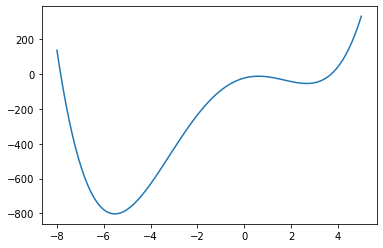

In [8]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

x = np.linspace(-8, 5, 100)
plt.plot(x, f(x))

In [9]:
solution = optimize.minimize_scalar(f, method='Brent')
print(solution)

     fun: -803.3955308825884
    nfev: 17
     nit: 11
 success: True
       x: -5.528801125219663


In [10]:
solution = optimize.minimize_scalar(f, method='bounded', bounds=[0, 6])
print(solution) # different algorithms return different objects

     fun: -54.21003937712762
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 2.668865104039653


#### Local and global minima

If the function is not trivial (and especially if it is in higher dimensions than 1), it may contain several minima. In these cases, care has to be taken to specify a good starting point, otherwise the algorithm will converge in a local (false) minimum.

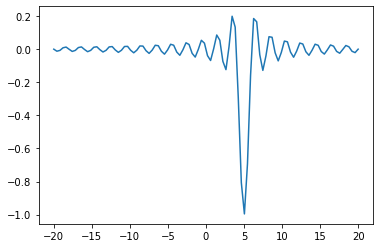

In [11]:
def f(x, offset):
    return -np.sinc(x - offset)

x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5))

In [12]:
# note how additional function arguments are passed in
solution = optimize.minimize_scalar(f, args=(5,))
print(solution)

     fun: -0.049029624014074166
    nfev: 15
     nit: 10
 success: True
       x: -1.4843871263953001


Optimization results are packed accordingly to this [format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult).

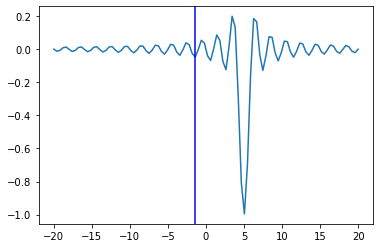

In [13]:
plt.plot(x, f(x, 5))
plt.axvline(solution['x'], color='b')

When the function oscillates a lot, often the global minimum is not found. To cope with that, several ranges needs to be explored. This can be done either manually...

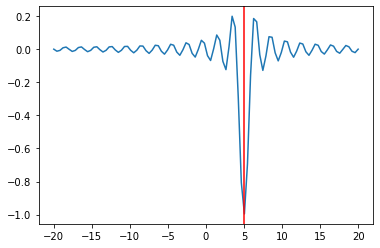

In [14]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
solutions = [optimize.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]
# split the x range in intervals, and run minimize_scalar in each one, then pick the interval with the smallest minimum
idx = np.argmin([solution['fun'] for solution in solutions])
solution = solutions[idx]

plt.plot(x, f(x, 5))
plt.axvline(solution['x'], color='r')

...or using dedicated methods which are specifically designed to overcome these issues:

In [17]:
from scipy.optimize import basinhopping

x0 = 10
# note how the parameters are passed to the function
solution = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)}) 
print(solution)

                        fun: -1.0
 lowest_optimization_result:       fun: -1.0
 hess_inv: array([[0.30397486]])
      jac: array([1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([5.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1212
                        nit: 100
                       njev: 606
                          x: array([5.])


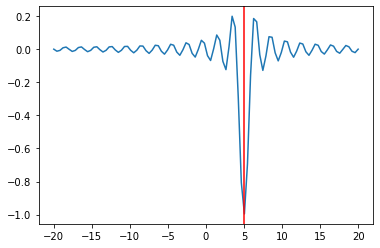

In [18]:
plt.plot(x, f(x, 5))
plt.axvline(solution['x'], color='r')

## Interpolation

Measurements typically sample continuous distributions, often values of such distributions are needed for which a measurement has not been performed. In this case possible choices are to fit the distribution with a predefined (biased!) function or interpolate the existing measurements. The latter is convenient when the measurements are dense and if the distribution is likely to be smooth.

The `scipy.interpolate` module is based on the FITPACK Fortran subroutines. The kind of interpolation can be specified: linear is the default;  *zero*, *slinear*, *quadratic* and *cubic* refer to a [spline](https://en.wikipedia.org/wiki/Spline_(mathematics)) interpolation of zeroth, first, second or third order; *previous* and *next* simply return the previous or next value of the point.

sin( 0.2 ): 0.9510565162951535 
 linear prediction: 0.9540652672667944 
 cubic prediction: 1.0001616768829587


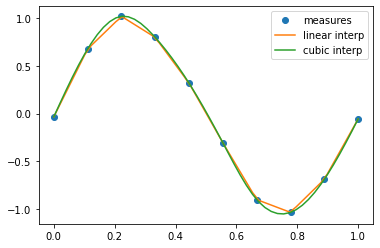

In [20]:
# the actual measurements
measured_time = np.linspace(0, 1, 10)
noise = (np.random.random(10)*2 - 1) * 1.e-1
measures = np.sin(2 * np.pi * measured_time) + noise

# import scipy.interpolate
from scipy.interpolate import interp1d
# 1D linear interpolation
linear_interp = interp1d(measured_time, measures)
# cubic interpolation
cubic_interp = interp1d(measured_time, measures, kind='cubic')

# denser interval to plot the interpolating function
interpolation_time = np.linspace(0, 1, 50)

plt.figure(figsize=(6, 4))
# plot the data
plt.plot(measured_time, measures, 'o', ms=6, label='measures')
# plot linear interpolation
linear_results = linear_interp(interpolation_time)
plt.plot(interpolation_time, linear_results, label='linear interp')
# plot cubic interpolation
cubic_results = cubic_interp(interpolation_time)
plt.plot(interpolation_time, cubic_results, label='cubic interp')
plt.legend()

# checking the punctual results
x = 0.2
print("sin(", x, "):", np.sin(2 * np.pi * x), "\n",
       "linear prediction:",linear_interp(x), "\n",
       "cubic prediction:", cubic_interp(x))

## Curve Fitting

Fitting is the core business of data analysis or in general data science. If you *know* the underlying model, then the overall problem is simple. If you don't, then it is a very delicate issue.

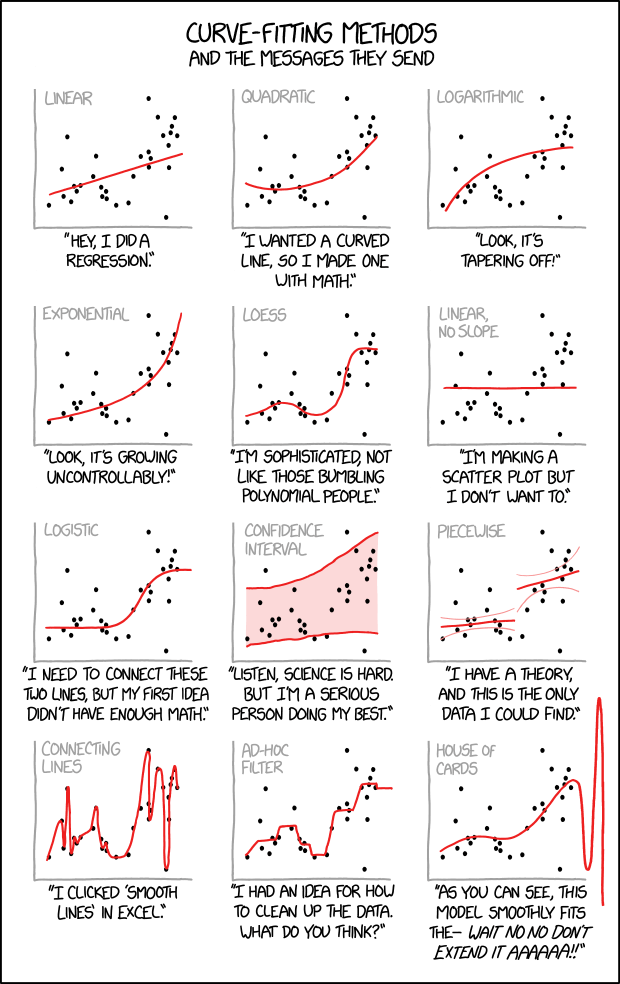

In [21]:
from IPython.display import Image
Image("xkcd_curve_fitting.png")

## Linear Regression

We have some data, $x$ and $y$, and we suppose there is a linear relation between them.
Thus, we want to fit a line to the data. Our model will be:

$$\hat{y} = \hat{\alpha} + \hat{\beta}x$$

where the symbol $\hat{}$ indicates our best estimate of that parameter.

For the sake of clarity, we define the following symbols:

* $\alpha$: the intercept
* $\hat{\alpha}$: our estimated best intercept
* $\beta$: the slope
* $\hat{\beta}$: our estimated best slope
* $\hat{y}$: our estimated y's, or in other words $f(x, \hat{\alpha}, \hat{\beta})$
* $x,y$: the data
* $\bar{x}$, $\bar{y}$: the average of $x,y$
* Residual: the difference between $\hat{y}$ and $y$ at a particular point ($\hat{y}_i - y_i$)
* Sum of squared residuals (SSR): $\sum_i (\hat{y}_i - y_i)^2$
* Total sum of squares (TSS): $\sum_i (\bar{y} - y_i)^2$, which is a kind of variance

One way to view this problem is as a minimization. Specifically, we want to have a function that returns a value of how good the estimate of our parameters is. As a matter of fact, our ultimate goal is to make $\hat{y}$ as close as possible to $y$. One of the most immediate choices is to take $\sum_i(\hat{y}_i - y_i)^2$, and minimize the resulting quantity. 
So we need to write down a function which takes in $\hat{\alpha}$ and $\hat{\beta}$ and returns how good the fit is:

$$f(\hat{\alpha}, \hat{\beta}) = \sum_i \left(y_i - \hat{\alpha} - \hat{\beta} x_i\right)^2$$

We can minimize this equation using any of our minimization techniques or we can do it analytically. In case of a linear regression, this can be easily done analytically.

Using calculus you can show that the minimum to $f(\alpha, \beta)$ is:

$$\hat{\beta} = \frac{\sum_i(x_i - \bar{x})(y_i - \bar{y})}{\sum_i(x_i - \bar{x})^2}$$

With a little bit of algebra, you can show this is

$$\hat{\beta} = \frac{\sigma_{xy}}{\sigma_x^2}$$

where $\sigma_{xy}$ is the sample covariance of $x$ and $y$ and $\sigma_x^2$ is the sample variance of $x$.

To find the intercept, you can just take the average of the residuals (not their squares!) given the model so far:

$$\hat{\alpha} = \frac{1}{N}\sum_i (y_i - \hat{\beta}x_i)$$

The uncertainties of $\hat{\alpha}$, $\hat{\beta}$ can be derived as well, but they strongly depend on the assumptions that you do on the uncertainties of the single points.


Under the assumption that the data points are normally distributed with mean $\hat{\beta}$ and variance $\sigma^2 / \sum (x_i - \hat{x})^2$, where $\sigma^2$ is the variance of the error terms, the uncertainties on the parameters $\alpha$ and $\beta$ can be derived as:

$$\sigma_\hat{\beta}^2 = \frac{\frac{SSR}{n-2}}{\sum (x_i - \bar{x})^2}$$

$$\sigma_\hat{\alpha}^2 = \sigma_\hat{\beta}^2 \frac{\sum x_i^2}{n}$$

Note that if you have a prior on the uncertainty on the single points, these uncertainties will not be valid and should be updated with the single point uncertainty terms!

Let's see the regression in action:

fitted alpha = 2.46 +- 0.71
fitted beta  = 2.21 +- 0.12
covariance:
 [[10.23391813 22.5939615 ]
 [22.5939615  52.5647829 ]]


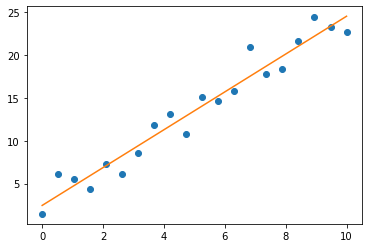

In [22]:
# generate some data with a linear relation + add some random noise
x = np.linspace(0, 10, 20)
y = 1 + x * 2.5 + np.random.normal(scale=2, size=20)

# get the covariance. Numpy conveniently provides the np.cov() method
cov = np.cov(x, y, ddof=2)
b_hat = cov[0, 1] / cov[0, 0]
a_hat = np.mean(y - b_hat * x)

n = len(x)
ssr = np.sum((y - (a_hat + b_hat * x))**2)
sigma_b = np.sqrt( (ssr/(n-2)) / np.sum((x - np.mean(x))**2) )
sigma_a = np.sqrt( sigma_b**2 * np.sum(x**2) / n )

print("fitted alpha = %.2f +- %.2f" % (a_hat, sigma_a))
print("fitted beta  = %.2f +- %.2f" % (b_hat, sigma_b))
print("covariance:\n", cov)

# plot resulting line
plt.plot(x, y, 'o')
plt.plot(x, a_hat + b_hat * x)
plt.show()

Notice that we didn't get exactly the correct answer: the points were generated with a slope of 2.5 and an intercept of 1, whereas our fit was a little bit off. But taking into account the uncertainties on the parameters, we can see that they are compatible with the initial values.

### Generic fitting

Let's create some data, sampled from a sine distribution and affected by random noise:

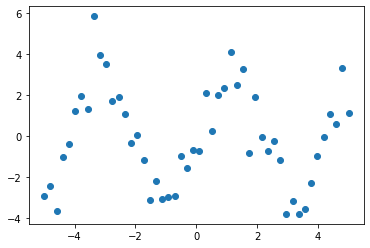

In [23]:
x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data)

This case is very straightfoward, because we *know* that the data is sampled from a sine function.

To find its parameters, in this case amplitude and (angular) frequency, we can call the `optimize.curve_fit()`, which accepts as arguments the fitting function, the data, and [much more](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). 

In [24]:
def f(x, A, nu):
    return A * np.sin(nu * x) # sine function with amplitude A and angular frequency

# fit by means of curve_fit
# p0 is a list of the initial guessed values for the parameters
popt, pcov = optimize.curve_fit(f, x_data, y_data, p0=[2, 2], full_output=False)
print("parameters:\n", popt)
print("covariance matrix:\n", pcov)
print("A = %.2f +- %.2f" % (popt[0], np.sqrt(pcov[0,0])))
print("f = %.2f +- %.2f" % (popt[1], np.sqrt(pcov[1,1])))

parameters:
 [3.09336916 1.48676192]
covariance matrix:
 [[ 0.04193559 -0.00044093]
 [-0.00044093  0.00045191]]
A = 3.09 +- 0.20
f = 1.49 +- 0.02


Note: the way curve_fit determines the uncertainty is to actually renormalize the errors so that the reduced $\chi^2$ (that is, the $\chi^2$/number of degrees of freedom) value is one, so the magnitude of the errors doesn't matter, only the relative errors. In some cases, when you have a prior on your uncertainites, you can specify `absolute_sigma=True` and pass an appropriate array containing the uncertainties in order to preserve the original errors.

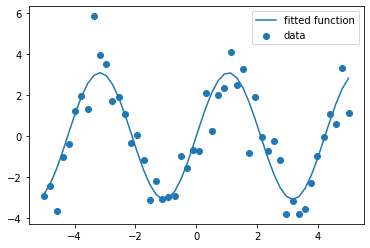

In [25]:
plt.scatter(x_data, y_data, label='data')
plt.plot(x_data, f(x_data, popt[0], popt[1]), label='fitted function')
plt.legend(loc='best')

## Goodness of Fit

There are a several ways to asses whether the function chosen fits well the data. There are different ways to perform a "goodness of fit". Two common methods are:

#### The correlation coefficient

One viable and quick way is to just compute the SSR, which stands for *sum of the squared residuals*. However, the SSR has the downside that it depends on the unit of $y$. Therefore, it's a good idea to divide the SSR by the TSS (*total sum of squares*), which has the same unit, so the result is a pure number:

$$R^2 = 1 - \frac{\textrm{SSR}}{\textrm{TSS}} = 1 - \frac{\sum_i \left(\hat{y}_i - y\right)^2}{\sum_i \left(\bar{y} - y\right)^2}$$

This equation has the property that it is unitless, and it is $1$ when the fit is perfect, and $0$ when the fit does not describe the data at all. In the case of linear regression, $R$ is the same as the correlation coefficient.

Let's take as an example our previous linear fit:

In [26]:
ssr = np.sum((y - a_hat - b_hat * x)**2)
tss = np.sum((np.mean(y) - y)**2)

rsq = 1 - ssr / tss

print("R2 =", rsq, "\nR =", np.sqrt(rsq))
print("Covariance matrix:\n", np.corrcoef(x,y)) # check with the correlation matrix that R is the correlation coefficient

R2 = 0.9489601064095644 
R = 0.9741458342617724
Covariance matrix:
 [[1.         0.97414583]
 [0.97414583 1.        ]]


#### The p-value

A proper goodness-of-fit test involves more than just some simple numerical estimator. The $\chi^2$ goodness of fit test is used to determine whether the sample data is consistent with a hypothesized distribution (in this case, a linear dependence, but it works for all data models). The $\chi^2$ goodness of fit test is appropriate when the data is randomly distributed, and the number of observations is not small, e.g. $\geq 5$.

In order to perform the test, we need to:

- determine the number of degrees of freedom of the fit, which is the number of data points - 1
- choose a figure of merit of how "good" the fit is, in this case the $\chi^2$, defined as:
$$\chi^2 = \sum_i \frac{(y_i - \hat{y}_i)^2}{\sigma_i^2}$$
- determine the **p-value**, which is the probability of observing a sample statistic as extreme as the test statistic. The $\chi^2$ as test statistics is a good choice, because it has a known distribution given the number of degrees of freedom and under the assumption that the data is randomly distributed. Thus, the p-value is the integral of the $\chi^2$ from the value returned from the fit to $+\infty$. When no scientific libraries were available, these values were tabulated, but nowadays `scipy.stats` provides a lot of these functions (including their cumulative distribution functions, which allow to quickly calculate the integral)

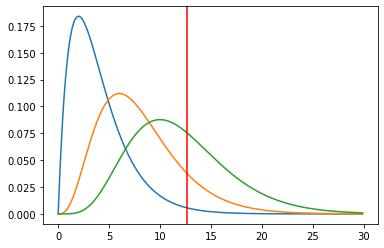

In [27]:
from scipy import stats

p = np.arange(0, 30, 0.1)
plt.plot(p, stats.chi2.pdf(p, df=4)) # very small p-value: model likely doesn't fit data
plt.plot(p, stats.chi2.pdf(p, df=8))
plt.plot(p, stats.chi2.pdf(p, df=12)) # very large p-value:
plt.axvline(12.7, color='r')

In our example, let's now assume (in order to use the $\chi^2$) that the data represents counts, whose uncertainty is known from the Poisson pdf and are simply $\sigma_{y_i} = \sqrt{y_i}$:

<ErrorbarContainer object of 3 artists>

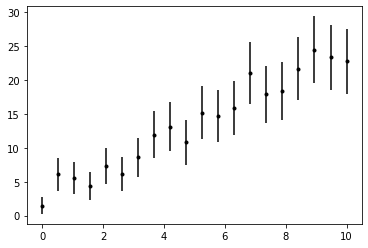

In [28]:
# assume random counts, e.g. sigma_i = sqrt(y_i). This is not always the case!
sigma_y = np.sqrt(np.abs(y)) 

# use plt.errorbar to plot points with the corresponding uncertainties
plt.errorbar(x, y, yerr=sigma_y, fmt='.k') 

n degrees of freedom = 19
chi2 = 14.623720198338619
p-value = 0.7461942148895302


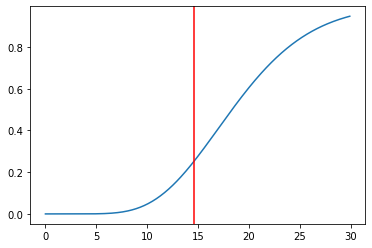

In [31]:
ndof = len(x) - 1
print("n degrees of freedom =", ndof)
# calculate the chi^2
chi2 = np.sum(((y - (a_hat + b_hat * x))**2) / sigma_y)
print("chi2 =", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

plt.plot(p, stats.chi2.cdf(p, df=ndof))
plt.fill_between(x, y, where=(x > chi2), color='lightblue')
plt.axvline(chi2, color='r')

(to be discussed only if time allows)

## The Fisher F-test

The method called **Fisher F-test** [[1](http://EconPapers.repec.org/RePEc:bla:istatr:v:80:y:2012:i:3:p:491-491)] [[2](https://doi.org/10.2307/2340521)] can help to determine the correct number of parameters in an appropriate family of functions (e.g. polynomials, exponentials, ...). From the statistical point of view, this method is not trivial at all because you need a prior on the choice of the function.

Please note that if you don't even have the knowledge of which family of functions to be used to fit the data, then the problem is more complex and the F-test is not applicable.

Instead, if you have a prior on the family of the function but not the exact number of parameters, the Fisher F-test provides an useful recipe.

The F-test is based on some fit quantities, such as the RSS (squared sum of the residuals of the fit) and the number of degrees of freedom. The test uses these quantities to iteratively compare one reference function and the function with one more parameter to determine whether or not the additional parameter is needed. If the simpler fit function is correct, the relative increase in the sum of squares is expected to be smaller than the relative increase in DOF:

$$\frac{SSR_1 - SSR_2}{SSR_2} \lesssim \frac{n_1 - n_2}{n_2}$$

the F-test is based on the test statistics that is defined as follows:

$$F = \left( \frac{SSR_1 - SSR_2}{n_2 - n_1} \right) / \left( \frac{SSR_2}{N - n_2} \right)$$

The F value is used to determine a CL after integrating the Fisher distribution from $F$ to $+\infty$, with $N$ the number of total degrees of freedom (bins):

$$CL = \int_F^{+\infty} \mathcal{F} d\mathcal{f}$$

which gives the CL under the null hypothesis of the simpler function being sufficient. If $CL < 10\%$, the simpler function is sufficient, otherwise, more parameters are needed. In the latter case, the Fisher test is repeated by increasing the number of parameters of both functions, until a function with a sufficient number of parameters is found.

SSR: 453.40868145608704 84.8489908378884 84.39786114121735
Test Linear vs Quadratic:
CL: 0.000 , additional parameter necessary: YES
Test Quadratic vs Cubic:
CL: 0.473 , additional parameter necessary: NO


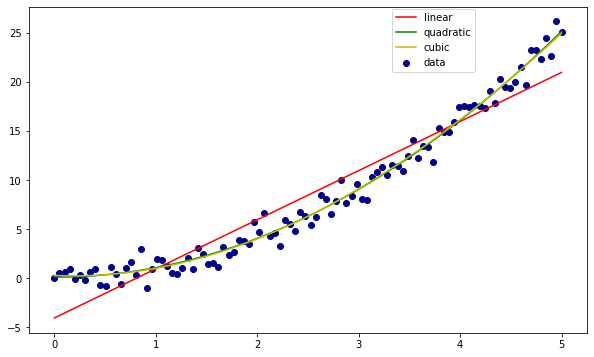

In [32]:
# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL


# generate data according to a certain distribution + random noise
N = 100
x = np.linspace(0, 5., N)
rnd = np.random.normal(size=(N))
y = x**2 + rnd

# plot
fig, ax = plt.subplots(figsize=(10, 6)) # create the figure and the axes
ax.scatter(x=x, y=y, marker='o', c='darkblue', label="data")

# define fitting functions
def f1(x, a0, a1):
    return a0 + a1 * x

def f2(x, a0, a1, a2):
    return a0 + a1 * x + a2 * x**2

def f3(x, a0, a1, a2, a3):
    return a0 + a1 * x + a2 * x**2 + a3 * x**3

(fa0, fa1), cov = optimize.curve_fit(f1, x, y)
y1 = f1(x, fa0, fa1)
ax.plot(x, y1, color='r', label="linear")
ssr_1 = np.sum((y1 - y)**2)
ndof_1 = 2 - 1 # n of parameters - 1

(fa0, fa1, fa2), cov = optimize.curve_fit(f2, x, y)
y2 = f2(x, fa0, fa1, fa2)
ax.plot(x, y2, color='g', label="quadratic")
ssr_2 = np.sum((y2 - y)**2)
ndof_2 = 3 - 1 # n of parameters - 1

(fa0, fa1, fa2, fa3), cov = optimize.curve_fit(f3, x, y)
y3 = f3(x, fa0, fa1, fa2, fa3)
ax.plot(x, y3, color='y', label="cubic")
ssr_3 = np.sum((y3 - y)**2)
ndof_3 = 4 - 1 # n of parameters - 1

ax.legend(loc=(0.65, 0.8))

print("SSR:", ssr_1, ssr_2, ssr_3)

# run F-test
# test f2 vs f1
print("Test Linear vs Quadratic:")
cl_1_vs_2 = Ftest(ssr_1, ssr_2, ndof_1, ndof_2, N, verbose=True)

print("Test Quadratic vs Cubic:")
cl_2_vs_3 = Ftest(ssr_2, ssr_3, ndof_2, ndof_3, N, verbose=True)